# **Tarea 3 - Simulación de un modelo de dos neuronas conectadas por sinapsis excitatoria**

### Considera las dos neuronas (A y B) que se muestran en la Figura 1:

### **Figura 1**
![Figura 1](Tarea3_Fig1.PNG)

### La neurona A recibe una corriente externa $I_{ext}$ y su potencial de accion $u_A(t)$ se comporta de acuerdo al modelo de Hodgkin-Huxley que vimos en la Clase 5. En esta tarea, vamos a modelar una sinapsis excitatoria para una segunda neurona B de tipo Hodgkin-Huxley. Esto es, vamos a predecir el potencial de accion $u_B(t)$ dada la **corriente sináptica** que recibe de parte de la neurona A

### Primero, recordemos que en una sinapsis, la neurona A expulsa un neurotransmisor $T$ el cual se une al receptor $r$ de la neurona B tal como se muestra en la Figura 2

### **Figura 2**
![Figura 2](Tarea3_Fig2.PNG)

### La concentración del neurotransmisor $T$ en la sinapsis depende de la diferencia entre el potencial de membrana de A y el potencial constante umbral llamado $V_P$:

$$T = \frac{T_{max}}{1 + e^{\frac{-(u_A - V_P)}{K_p}}}$$

### Ahora, la concentración de receptores en la membrana de la neurona B se modela con la siguiente ecuación diferencial
$$\frac{dr}{dt} = \alpha_rT(1-r) - \beta_rr$$

### La interacción de los neurotransmisores de A con los receptores de B da lugar a una **corriente sináptica** $I_{sin}$ dada por:

$$I_{sin} = g_{GABA}r(u_B - E_{Cl})$$

### Nota que ambas neuronas A y B obedecen el modelo de Hodgkin-Huxley como lo vimos en clase. Esto es, el potencial de la neurona A $u_A(t)$ esta dado por la siguiente ecuación diferencial:

$$\frac{du_A}{dt} = \frac{I_{ext,A}(t) - \sum_k I_{k,A}(t)}{C}$$

### Sin embargo, la ecuación diferencial para calcular el potencial de la neurona B $u_B(t)$ contiene una tercera corriente (la corriente sináptica):

$$\frac{du_B}{dt} = \frac{I_{ext,B}(t) - \sum_k I_{k,B}(t) - I_{sin}}{C}$$

# **Modelo Hodgkin-Huxley de neurona A**

Recuerda que el modelo de Hodgkin-Huxley requiere de al menos 10 funciones **por neurona** (4 ecuaciones diferenciales y 6 funciones). Abajo se muestran las ecuaciones de la neurona A (nota los subíndices que especifican que estamos hablando de la neurona A):

$$\alpha_{n,A} = \frac{0.02(u_A-25)}{1-e^{-(u_A-25)/9}}$$

$$\alpha_{m,A} = \frac{0.182(u_A+35)}{1-e^{-(u_A+35)/9}}$$

$$\alpha_{h,A}= 0.25e^{-(u_A+90)/12}$$

$$\beta_{n,A} = \frac{-0.002(u_A-25)}{1-e^{(u_A-25)/9}}$$

$$\beta_{m,A} = \frac{-0.124(u_A+35)}{1-e^{(u_A+35)/9}}$$

$$\beta_{h,A} = \frac{0.25e^{(u_A+62)/6}}{e^{(u_A+90)/12}}$$

$$\frac{dn_A}{dt} = \alpha_{n,A}(1-n_A) - \beta_{n,A}n_A$$

$$\frac{dm_A}{dt} = \alpha_{m,A}(1-m_A) - \beta_{m,A}m_A$$

$$\frac{dh_A}{dt} = \alpha_{h,A}(1-h_A) - \beta_{h,A}h_A$$

$$\frac{du_A}{dt} = \frac{I_{ext,A}(t) - \sum_k I_{k,A}(t)}{C}$$

Donde

$$\sum_k I_{k,A}(t) = g_{Na}m_A^3h_A(u_A-E_{Na}) + g_{K}n_A^4(u_A-E_{K}) + g_{Cl}(u_A-E_{Cl})$$

 En el código de abajo definimos el modelo de Hodgkin-Huxley en Python como lo hicimos en la Clase 5. No hay necesidad de completar codigo, el modelo completo ya esta definido

In [1]:
# Importa las librerias de Python necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

In [2]:
#############################################################################
### Define las funciones que calculan, alphas y Betas dado un potencial u ###
#############################################################################

def alpha_n(u):
    return ( 0.02*(u-25.0) )/( 1.0 - np.exp( -(u-25.0)/9.0 ) )

# Define una function que calcula alpha_m dado un valor de u
def alpha_m(u):
    return ( 0.182*(u+35.0) )/( 1.0 - np.exp( -(u+35.0)/9.0 ) )

# Define una function que calcula alpha_h dado un valor de u
def alpha_h(u):
    return 0.25* np.exp( -(u+90.0)/12.0 )

# Define una funcion que calcula beta_n dado un valor de u
def beta_n(u):
    return ( -0.002*(u-25.0) )/( 1.0 - np.exp( (u-25)/9 ) )

# Define una function que calcula beta_m dado un valor de u
def beta_m(u):
    return ( -0.124*(u+35) )/( 1.0 - np.exp( (u+35)/9 ) )

# Define una function que calcula beta_h dado un valor de u
def beta_h(u):
    return ( 0.25*np.exp( (u+62.0)/6.0 ) )/( np.exp( (u+90.0)/12.0) )

####################################################
### Define las ecuaciones diferenciales de m,n,h ###
####################################################

# Define una funcion que calcula dn/dt dado un valor de u y de n
def dndt(u,n):
    a_n = alpha_n(u) # Aqui estamos mandando llamar la funcion alpha_n que definimos arriba
    b_n = beta_n(u)
    return a_n * (1 - n) - (b_n*n)

def dmdt(u,m):
    a_m = alpha_m(u)
    b_m = beta_m(u)
    return a_m * (1 - m) - (b_m*m)

def dhdt(u,h):
    a_h = alpha_h(u)
    b_h = beta_h(u)
    return a_h * (1 - h) - (b_h*h)

##############################################################
### Define las funciones para calcular la corriente ionica ###
##############################################################

# Define una funcion que calcula I_Na dados los valores de u, m, h
def I_Na(u,m,h):
    E_Na = 55.0
    g_Na = 40.0
    return (g_Na * (m**3) * h) * (u - E_Na)

# Define una funcion que calcula I_K dados los valores de u, n
def I_K(u,n):
    E_K = -77.0
    g_K = 35.0
    return (g_K * (n**4)) * (u - E_K)

# Define una funcion que calcula I_Cl dado el valor de u
def I_Cl(u):
    E_Cl = -65.0
    g_Cl = 0.3
    return g_Cl * (u - E_Cl)

def SumaIonicas(u,m,n,h):
    return I_Na(u,m,h) + I_K(u,n) + I_Cl(u)

#############################################################
### Define la ecuacion diferencial para el potencial de A ###
#############################################################

# Funcion que calcula du/dt dado un valor de corriente externa y un valor de suma de corrientes ionicas
# NOTA, esta funcion no toma en cuenta corriente sinaptica porque estamos hablando de la neurona A
def dudt_a(Iext,Isuma_ion):
    # Define constante de capacitancia
    C = 1.0
    return (Iext - Isuma_ion)/C

###############################################################
### Define la funcion del modelo de Hodgkin-Huxley completo ###
###############################################################

def HodgkinHuxley(condiciones_iniciales, t, I_externa):
    
    # En este sistema, la variable "condiciones_iniciales" contiene los valores de [u,m,n,h] en un momento dado
    u = condiciones_iniciales[0]
    m = condiciones_iniciales[1]
    n = condiciones_iniciales[2]
    h = condiciones_iniciales[3]
    
    # Primero, calculamos las derivadas de m,n,h
    Dm = dmdt(u,m)
    Dn = dndt(u,n)
    Dh = dhdt(u,h)
    
    # Ahora calculamos la derivada de u
    Isuma_ion = SumaIonicas(u,m,n,h)
    Du = dudt_a(I_externa, Isuma_ion)
    
    # La funcion debe regresar el valor de las cuatro derivadas calculadas
    return [Du,Dm,Dn,Dh]

# **Problema 1 - Confirma que el modelo de la neurona A funciona y calcula $u_A(t)$**

Vamos a asumir que, como lo hicimos en clase, el potencial de reposo de la neurona A es -65 mV. Por lo que las condiciones iniciales para la neurona A son:

$$u_A(0) = -65 mV$$
$$n_A(0) = m_A(0) = h_A(0) = 0$$

Para la corriente externa aplicada a A, usaremos un tren de impulsos con duracion de 2 ms con una corriente de 100 mA durante un tiempo total de 210 ms

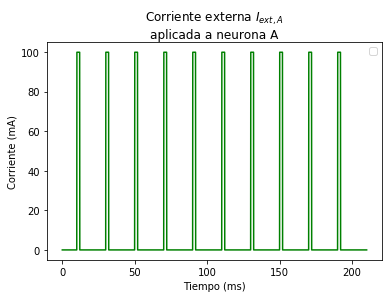

In [3]:
# Define el numero de pasos
pasos = 2000

# Define el vector tiempo
tiempo = np.linspace(0.0,210.0,pasos) # Simularemos un tiempo total de 100 ms

# Inicializa el tren de impulsos de Iext_A(t)
I_ext_A = np.zeros_like(tiempo)

# Haremos un ciclo FOR para crear un impulso de 100 mA cada 10 ms
t_impulsos = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
t_duracion = 2

for i in range(len(t_impulsos)):
    I_ext_A[tiempo>t_impulsos[i]] = 100.0
    I_ext_A[tiempo>t_impulsos[i]+t_duracion] = 0.0

# Grafica I_ext_A para que veas la forma de la onda de entrada a la neurona
plt.figure(figsize=(6,4))
plt.plot(tiempo,I_ext_A,'g')
plt.ylabel('Corriente (mA)')
plt.xlabel('Tiempo (ms)')
plt.title('Corriente externa $I_{ext,A}$\naplicada a neurona A')
plt.legend()

### Ahora completa el codigo de abajo para resolver y graficar el potencial $u_A(t)$

In [4]:
# Crea una lista con condiciones iniciales de la neurona A
ciA = [-65.0, 0.0, 0.0, 0.0] # Completa aqui con los valores inicialesde u_A(0), m_A(0), n_A(0), h_A(0)

# Define los vectores u(t), n(t), m(t), h(t) para guardar la solucion
uA_t = np.empty_like(tiempo)
mA_t = np.empty_like(tiempo)
nA_t = np.empty_like(tiempo)
hA_t = np.empty_like(tiempo)

# Inicializa el valor de u_t
uA_t[0] = ciA[0] # Completa aqui con los valores que definiste arriba de ciA
mA_t[0] = ciA[1]
nA_t[0] = ciA[2]
hA_t[0] = ciA[3]

# Resuelve el sistema de EDO de Hodgkin-Huxley paso a paso con un ciclo FOR
for i in range(1,len(tiempo)):
    # Iniciamos el iterador en 1 porque el valor 0 ya lo definimos arriba
    # Define el tamano del paso en el tiempo
    tpaso = [tiempo[i-1],tiempo[i]]
    
    # Resuelve las ecuaciones diferenciales del model HH en el tiempo que abarca el paso
    
    # NOTA QUE EN LOS ARGUMENTOS (args) DE ESTA FUNCION LA ENTRADA ES EL IMPULSO I_ext_A que definimos arriba 
    z = odeint(HodgkinHuxley,ciA,tpaso,args=(I_ext_A[i-1],))
    
    # La variable "z" captura los valores de u,m,n,h en dos puntos en el tiempo:
    # Estos cuatro valores en el tiempo son los que estan dentro de "tpaso"
    
    uA_t[i] = z[1][0] # Completa aqui con los valores correspondientes
    mA_t[i] = z[1][1]
    nA_t[i] = z[1][2]
    hA_t[i] = z[1][3]
    
    # Actualiza las condiciones iniciales
    ciA = z[1]

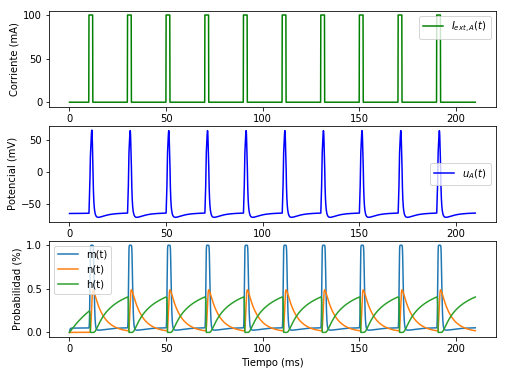

In [5]:
# Grafica los resultados
plt.figure(figsize=(8,6))
plt.title('Potencial $u_A(t)$ de neurona A')
plt.subplot(3,1,1)
plt.plot(tiempo,I_ext_A,'g',label='$I_{ext,A}(t)$')
plt.ylabel('Corriente (mA)')
plt.xlabel('Tiempo (ms)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(tiempo,uA_t,'b',label='$u_A(t)$')
plt.ylabel('Potencial (mV)')
plt.xlabel('Tiempo (ms)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(tiempo,mA_t,label='m(t)')
plt.plot(tiempo,nA_t,label='n(t)')
plt.plot(tiempo,hA_t,label='h(t)')
plt.ylabel('Probabilidad (%)')
plt.xlabel('Tiempo (ms)')
plt.legend()

# ** Problema 2 - Construye el modelo de Hodgkin-Huxley de la neurona B**

### Ahora que ya tienes calculado $u_A(t)$, puedes usar este potencial para calcular $u_B(t)$. Definir las funciones para la neurona B es muy parecido a como definimos las funciones para A. 

### Nota que puedes reusar las funciones del problema 1 para calcular las alphas, las betas, las derivadas de m,n,h y la corriente iónica. Lo que vamos a agregar para la neurona B son las ecuaciones para calcular (1) la concentración de neurotransmisores ($T$), (2) la tasa de cambio de receptores $r$, (3) y la corriente sináptica $I_{sin}$ que depende del valor de $u_A(t)$

### **Parte 2.1 - Define la función **conc_T** para calcular la concentración de $T$ dado un valor de $u_A(t)$**

$$T = \frac{T_{max}}{1 + e^{\frac{-(u_A - V_P)}{K_p}}}$$

Completa el código a continuación

In [6]:
# Función que calcula  la concentración de neurotransmisor T dado un valor de potencial de la neurona A (uA_t)
def conc_T(uA):
    Kp = 5.0
    Vp = 7.0
    Tmax = 1.5
    T = Tmax / (1 + np.exp(-(uA - Vp)/Kp))# Completa el codigo aqui
    return T

### **Parte 2.2 - Define la ecuación diferencial **drdt** para calcular la tasa de cambio de concentración de receptores en la membrana de la neurona B**

$$\frac{dr}{dt} = \alpha_rT(1-r) - \beta_rr$$

Completa el código a continuación

In [7]:
def drdt(r,T):
    alpha_r = 5.0
    beta_r = 0.18
    Dr = alpha_r * T * (1 - r) - beta_r*r # Completa el codigo aqui
    return Dr

### **Parte 2.3 - Define la función que calcula el valor de la corriente sináptica $I{sin}$ dados los valores de $g_{GABA}$, $r$ y de $u_B$**

(NOTA: $g_{GABA}$ denota la conductancia del neurotransmisor, en este caso, "gamma-aminobutiric acid"

$$I_{sin} = g_{GABA}r(u_B - E_{Cl})$$

Completa el código a continuación

In [8]:
def Isinaptica(gGABA,r,uB):
    E_Cl = E_Cl = -65.0
    I_sin = gGABA * r * (uB - E_Cl) # Completa el codigo aqui
    return I_sin

### **Parte 2.4 - Define la función que calcula la derivada $\frac{du_B}{dt}$ dados los valores la corriente externa ($I_{ext,B}$), la suma de las corrientes iónicas $\sum_k I_{k,B}(t)$ y la corriente sináptica ($I_{sin}$)**

$$\frac{du_B}{dt} = \frac{I_{ext,B}(t) - \sum_k I_{k,B}(t) - I_{sin}}{C}$$

Completa el código a continuación

In [9]:
def dudt_b(Iext, Isuma_ion, I_sin):
    # Define constante de capacitancia
    C = 1.0
    duBdt = (Iext - Isuma_ion - I_sin)/C# Completa el codigo aqui 
    return duBdt

### **Parte 2.5 - Define la función de Hodgkin-Huxley (**HodgkinHuxley_B**) de abajo para calcular las derivadas de $u_B, m_B, n_B, h_B, r$**

### Nota que en esta función, necesitamos ingresar 5 condiciones iniciales:

* $u_B$
* $m_B$
* $n_B$
* $h_B$
* $r$

### También nota que esta función de Hodgkin-Huxley toma como entradas el valor de $gGABA$ y de $u_A$

Completa el código a continuación

In [10]:
def HodgkinHuxley_B(condiciones_iniciales, t, I_externa_B, gGABA, uA):
    
    # En este sistema, la variable "condiciones_iniciales" contiene los 5 valores de [uB,mB,nB,hB,r]
    uB = condiciones_iniciales[0]
    mB = condiciones_iniciales[1]
    nB = condiciones_iniciales[2]
    hB = condiciones_iniciales[3]
    r = condiciones_iniciales[4]
        
    # Primero, calculamos las derivadas de m,n,h (recuerda que las entradas con uB, mB, nB y hB)
    Dm_B = dmdt(uB,mB) # Completa el codigo aqui
    Dn_B = dndt(uB,nB) # Completa el codigo aqui
    Dh_B = dhdt(uB,hB) # Completa el codigo aqui
    
    # Segundo, calculamos la concentracion de T dado uA
    T = conc_T(uA) # Completa el codigo aqui
    
    # Tercero, ahora que tenemos el valor de T, podemos calcular drdt
    Dr = drdt(r,T) # Completa el codigo aqui
    
    # Cuarto, calculamos la corriente ionica en neurona B
    Isuma_ion_B = SumaIonicas(uB,mB,nB,hB) # Completa el codigo aqui
    
    # Quinto, calculamos la corriente sinaptica
    I_sin = Isinaptica(gGABA, r, uB) # Completa el codigo aqui
    
    # Finalmente, calculamos la derivada de uB
    Du_B = dudt_b(I_externa_B, Isuma_ion_B, I_sin)
    
    # La funcion debe regresar el valor de las cinco derivadas calculadas (Du_B, Dm_B, Dn_B, Dh_B, Dr)
    return [Du_B,Dm_B,Dn_B,Dh_B,Dr]

### **Parte 2.6 - Define la corriente externa $I_{ext,B}$ que vamos a aplicar a la neurona B**

### En este caso, vamos a aplicar una corriente externa constante de 10 mA durante 210 ms (el mismo tiempo que en la simulacion de la neurona A)

Completa el código a continuación

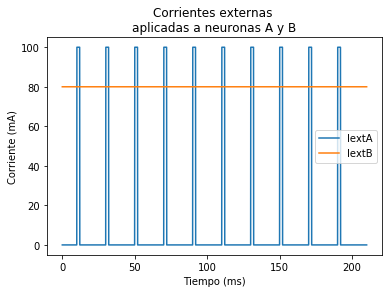

In [11]:
# Define el numero de pasos
pasos = 2000

# Define el vector tiempo
tiempo = np.linspace(0.0,210.0,pasos) # Simularemos un tiempo total de 100 ms

# Deine el valor de Iext_B(t)
I_ext_B = np.ones_like(tiempo) * 80.0

# Grafica I_ext_A e I_ext_B para que veas la forma de la onda de entrada a las dos neuronas en una misma grafica
plt.figure(figsize=(6,4))
plt.plot(tiempo,I_ext_A, label='IextA')

# Completa el codigo aqui
plt.plot(tiempo,I_ext_B,label='IextB')

plt.ylabel('Corriente (mA)')
plt.xlabel('Tiempo (ms)')
plt.title('Corrientes externas \naplicadas a neuronas A y B')
plt.legend()

### **Parte 2.7 - Resuelve el modelo Hodgkin-Huxley de la neurona B**

### Las condiciones iniciales que vamos a utilizar son:

$$u_B(0) = -65.0$$
$$m_B(0) = 0$$
$$n_B(0) = 0$$
$$h_B(0) = 0$$
$$r(0) = 0$$

### Además, el valor de $gGABA$ que usaremos será de 0.1 (en el problema 3, vas a tener que graficar la solucion de $u_B(t)$ para varios valores de $gGABA$

Completa el codigo a continuacion

In [12]:
# Crea una lista con condiciones iniciales de la neurona B [uA,uB,m,n,h,r]
ciB = [-65.0, 0.0, 0.0, 0.0, 0.0] # Aqui pondremos los valores iniciales de u_B(0), m_B(0), n_B(0), h_B(0), r(0)

# Define los vectores uB(t), nB(t), mB(t), hB(t), r(t) para guardar la solucion
uB_t = np.empty_like(tiempo)
mB_t = np.empty_like(tiempo) # Completa aqui
nB_t = np.empty_like(tiempo) # Completa aqui
hB_t = np.empty_like(tiempo) # Completa aqui
r_t = np.empty_like(tiempo) # Completa aqui

# Inicializa el valor de uB_t

uB_t[0] = ciB[0] # Completa aqui
mB_t[0] = ciB[1]
nB_t[0] = ciB[2]
hB_t[0] = ciB[3]
r_t[0] = ciB[4]

# Define el valor de gGABA
gGABA = 0.1

# Resuelve el sistema de EDO de Hodgkin-Huxley de la neurona B paso a paso con un ciclo FOR
for i in range(1,len(tiempo)):
    # Iniciamos el iterador en 1 porque el valor 0 ya lo definimos arriba
    # Define el tamano del paso en el tiempo
    tpaso = [tiempo[i-1],tiempo[i]]
    
    # Resuelve las ecuaciones diferenciales del modelo HH en el tiempo que abarca el paso
    
    # NOTA QUE EN LOS ARGUMENTOS (args) DE ESTA FUNCION LA ENTRADA ES EL IMPULSO I_ext_B, gGABA y el valor de uA en t=tiempo(i) que calculamos arriba 
    z = odeint(HodgkinHuxley_B, ciB, tpaso, args=(I_ext_B[i-1],gGABA,uA_t[i-1]))
    
    # RECUERDA la variable "z" captura 5 valores [uB,mB,nB,hB,r] en dos puntos en el tiempo:
    
    uB_t[i] = z[1][0] # Completa aqui con los valores correspondientes
    mB_t[i] = z[1][1]
    nB_t[i] = z[1][2]
    hB_t[i] = z[1][3]
    r_t[i] = z[1][4]
    
    # Actualiza las condiciones iniciales
    ciB = z[1]

### **Parte 2.8 - Grafica los resultados**

### Haz dos gráficas

* Grafica $u_A(t)$ y $u_B(t)$ juntas con respecto al tiempo
* Grafica los valores de mB, nB, hB y r con respecto al tiempo

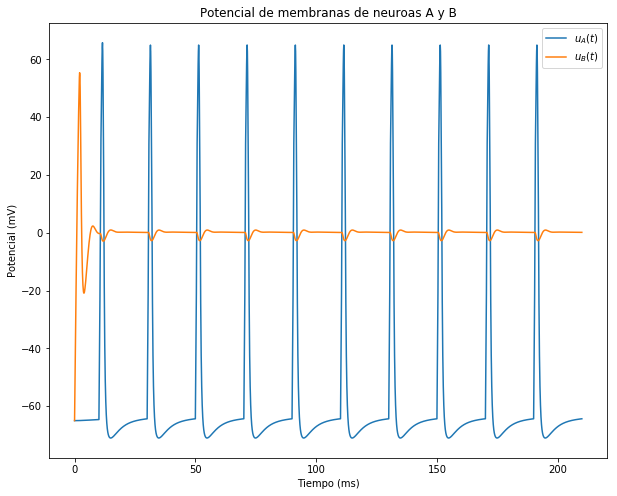

In [13]:
# Grafica I_ext_A e I_ext_B para que veas la forma de la onda de entrada a las dos neuronas en una misma grafica
plt.figure(figsize=(10,8))
plt.plot(tiempo,uA_t, label='$u_A(t)$')
# Completa el codigo aqui
plt.plot(tiempo,uB_t, label='$u_B(t)$')

plt.ylabel('Potencial (mV)')
plt.xlabel('Tiempo (ms)')
plt.title('Potencial de membranas de neuroas A y B')
plt.legend()

# **Problema 3 - Variación de la respuesta de B a diferentes valores de $gGABA$**

### Vuelve a calcular $u_B(t)$ como lo hicimos en el problema 2.7 pero ahora usando 3 valores distintos de $gGABA$ {0.2, 0.6, 1.0} y grafica los tres casos junto con $u_A(t)$

In [16]:
# Crea una lista con condiciones iniciales de la neurona B [uA,uB,m,n,h,r]
ciB = [-65.0, 0.0, 0.0, 0.0, 0.0] # Aqui pondremos los valores iniciales de u_B(0), m_B(0), n_B(0), h_B(0), r(0)

# Define los vectores uB(t), nB(t), mB(t), hB(t), r(t) para guardar la solucion
uB_t = np.empty_like(tiempo)
mB_t = np.empty_like(tiempo) # Completa aqui
nB_t = np.empty_like(tiempo) # Completa aqui
hB_t = np.empty_like(tiempo) # Completa aqui
r_t = np.empty_like(tiempo) # Completa aqui

# Inicializa el valor de uB_t

uB_t[0] = ciB[0] # Completa aqui
mB_t[0] = ciB[1]
nB_t[0] = ciB[2]
hB_t[0] = ciB[3]
r_t[0] = ciB[4]

# Define el valor de gGABA
gGABA = 0.2

# Resuelve el sistema de EDO de Hodgkin-Huxley de la neurona B paso a paso con un ciclo FOR
for i in range(1,len(tiempo)):
    # Iniciamos el iterador en 1 porque el valor 0 ya lo definimos arriba
    # Define el tamano del paso en el tiempo
    tpaso = [tiempo[i-1],tiempo[i]]
    
    # Resuelve las ecuaciones diferenciales del modelo HH en el tiempo que abarca el paso
    
    # NOTA QUE EN LOS ARGUMENTOS (args) DE ESTA FUNCION LA ENTRADA ES EL IMPULSO I_ext_B, gGABA y el valor de uA en t=tiempo(i) que calculamos arriba 
    z = odeint(HodgkinHuxley_B, ciB, tpaso, args=(I_ext_B[i-1],gGABA,uA_t[i-1]))
    
    # RECUERDA la variable "z" captura 5 valores [uB,mB,nB,hB,r] en dos puntos en el tiempo:
    
    uB_t[i] = z[1][0] # Completa aqui con los valores correspondientes
    mB_t[i] = z[1][1]
    nB_t[i] = z[1][2]
    hB_t[i] = z[1][3]
    r_t[i] = z[1][4]
    
    # Actualiza las condiciones iniciales
    ciB = z[1]

uB_t_g02 = uB_t

# Para gGABA = 0.6

In [17]:
# Crea una lista con condiciones iniciales de la neurona B [uA,uB,m,n,h,r]
ciB = [-65.0, 0.0, 0.0, 0.0, 0.0] # Aqui pondremos los valores iniciales de u_B(0), m_B(0), n_B(0), h_B(0), r(0)

# Define los vectores uB(t), nB(t), mB(t), hB(t), r(t) para guardar la solucion
uB_t = np.empty_like(tiempo)
mB_t = np.empty_like(tiempo) # Completa aqui
nB_t = np.empty_like(tiempo) # Completa aqui
hB_t = np.empty_like(tiempo) # Completa aqui
r_t = np.empty_like(tiempo) # Completa aqui

# Inicializa el valor de uB_t

uB_t[0] = ciB[0] # Completa aqui
mB_t[0] = ciB[1]
nB_t[0] = ciB[2]
hB_t[0] = ciB[3]
r_t[0] = ciB[4]

# Define el valor de gGABA
gGABA = 0.6

# Resuelve el sistema de EDO de Hodgkin-Huxley de la neurona B paso a paso con un ciclo FOR
for i in range(1,len(tiempo)):
    # Iniciamos el iterador en 1 porque el valor 0 ya lo definimos arriba
    # Define el tamano del paso en el tiempo
    tpaso = [tiempo[i-1],tiempo[i]]
    
    # Resuelve las ecuaciones diferenciales del modelo HH en el tiempo que abarca el paso
    
    # NOTA QUE EN LOS ARGUMENTOS (args) DE ESTA FUNCION LA ENTRADA ES EL IMPULSO I_ext_B, gGABA y el valor de uA en t=tiempo(i) que calculamos arriba 
    z = odeint(HodgkinHuxley_B, ciB, tpaso, args=(I_ext_B[i-1],gGABA,uA_t[i-1]))
    
    # RECUERDA la variable "z" captura 5 valores [uB,mB,nB,hB,r] en dos puntos en el tiempo:
    
    uB_t[i] = z[1][0] # Completa aqui con los valores correspondientes
    mB_t[i] = z[1][1]
    nB_t[i] = z[1][2]
    hB_t[i] = z[1][3]
    r_t[i] = z[1][4]
    
    # Actualiza las condiciones iniciales
    ciB = z[1]

uB_t_g06 = uB_t

# Para gGABA = 1.0

In [18]:
# Crea una lista con condiciones iniciales de la neurona B [uA,uB,m,n,h,r]
ciB = [-65.0, 0.0, 0.0, 0.0, 0.0] # Aqui pondremos los valores iniciales de u_B(0), m_B(0), n_B(0), h_B(0), r(0)

# Define los vectores uB(t), nB(t), mB(t), hB(t), r(t) para guardar la solucion
uB_t = np.empty_like(tiempo)
mB_t = np.empty_like(tiempo) # Completa aqui
nB_t = np.empty_like(tiempo) # Completa aqui
hB_t = np.empty_like(tiempo) # Completa aqui
r_t = np.empty_like(tiempo) # Completa aqui

# Inicializa el valor de uB_t

uB_t[0] = ciB[0] # Completa aqui
mB_t[0] = ciB[1]
nB_t[0] = ciB[2]
hB_t[0] = ciB[3]
r_t[0] = ciB[4]

# Define el valor de gGABA
gGABA = 1.0

# Resuelve el sistema de EDO de Hodgkin-Huxley de la neurona B paso a paso con un ciclo FOR
for i in range(1,len(tiempo)):
    # Iniciamos el iterador en 1 porque el valor 0 ya lo definimos arriba
    # Define el tamano del paso en el tiempo
    tpaso = [tiempo[i-1],tiempo[i]]
    
    # Resuelve las ecuaciones diferenciales del modelo HH en el tiempo que abarca el paso
    
    # NOTA QUE EN LOS ARGUMENTOS (args) DE ESTA FUNCION LA ENTRADA ES EL IMPULSO I_ext_B, gGABA y el valor de uA en t=tiempo(i) que calculamos arriba 
    z = odeint(HodgkinHuxley_B, ciB, tpaso, args=(I_ext_B[i-1],gGABA,uA_t[i-1]))
    
    # RECUERDA la variable "z" captura 5 valores [uB,mB,nB,hB,r] en dos puntos en el tiempo:
    
    uB_t[i] = z[1][0] # Completa aqui con los valores correspondientes
    mB_t[i] = z[1][1]
    nB_t[i] = z[1][2]
    hB_t[i] = z[1][3]
    r_t[i] = z[1][4]
    
    # Actualiza las condiciones iniciales
    ciB = z[1]

uB_t_g1 = uB_t

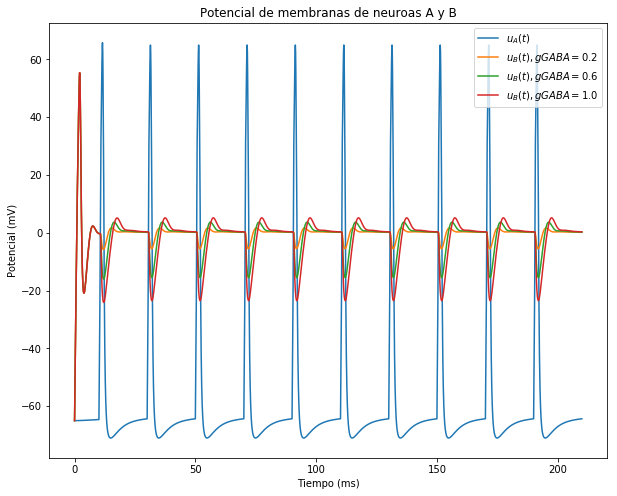

In [19]:
# Grafica I_ext_A e I_ext_B para que veas la forma de la onda de entrada a las dos neuronas en una misma grafica
plt.figure(figsize=(10,8))
plt.plot(tiempo,uA_t, label='$u_A(t)$')
# Completa el codigo aqui
plt.plot(tiempo,uB_t_g02, label='$u_B(t), gGABA = 0.2$')
#plt.plot(tiempo,uB_t_g04, label='$u_B(t), gGABA = 0.4$')
plt.plot(tiempo,uB_t_g06, label='$u_B(t), gGABA = 0.6$')
#plt.plot(tiempo,uB_t_g08, label='$u_B(t), gGABA = 0.8$')
plt.plot(tiempo,uB_t_g1, label='$u_B(t), gGABA = 1.0$')

plt.ylabel('Potencial (mV)')
plt.xlabel('Tiempo (ms)')
plt.title('Potencial de membranas de neuroas A y B')
plt.legend()

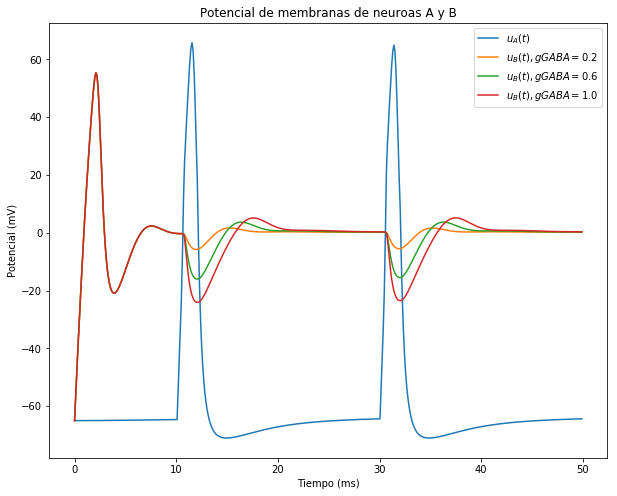

In [20]:
# Grafica I_ext_A e I_ext_B para que veas la forma de la onda de entrada a las dos neuronas en una misma grafica
plt.figure(figsize=(10,8))
plt.plot(tiempo[tiempo<=50],uA_t[tiempo<=50], label='$u_A(t)$')
# Completa el codigo aqui
plt.plot(tiempo[tiempo<=50],uB_t_g02[tiempo<=50], label='$u_B(t), gGABA = 0.2$')
#plt.plot(tiempo,uB_t_g04, label='$u_B(t), gGABA = 0.4$')
plt.plot(tiempo[tiempo<=50],uB_t_g06[tiempo<=50], label='$u_B(t), gGABA = 0.6$')
#plt.plot(tiempo,uB_t_g08, label='$u_B(t), gGABA = 0.8$')
plt.plot(tiempo[tiempo<=50],uB_t_g1[tiempo<=50], label='$u_B(t), gGABA = 1.0$')

plt.ylabel('Potencial (mV)')
plt.xlabel('Tiempo (ms)')
plt.title('Potencial de membranas de neuroas A y B')
plt.legend()